# PREDİCT FUTURE SALES
#### 1- Checking For Null Values
#### 2- Overwiev About Outliers
#### 3- Exploratory Data Analysis
#### 4- Clustering The Data
#### 5- Applying XGBoost
#### 6- Applying RNN Model

In [1]:
# Importing the usefull libraries
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from scipy.stats.mstats import winsorize
import time

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import yellowbrick 
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Concatenate

import warnings
warnings.filterwarnings("ignore")
title_font= {"family": "arial", "weight": "bold", "color": "darkred", "size":13}
label_font= {"family": "arial", "weight": "bold", "color": "darkblue", "size":10}

/Users/ahmetemintek/project-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



In [2]:
df_train= pd.read_csv("/Users/ahmetemintek/Desktop/bitirme_projesi/sales_train.csv") #This is the train data
df_item= pd.read_csv("/Users/ahmetemintek/Desktop/bitirme_projesi/items.csv") #This dataset includes names of items.
df_category= pd.read_csv("/Users/ahmetemintek/Desktop/bitirme_projesi/item_categories.csv") #This dataset includes category names of items.
df_shop= pd.read_csv("/Users/ahmetemintek/Desktop/bitirme_projesi/shops.csv")  #This dataset include name of shops. 
df_test= pd.read_csv("/Users/ahmetemintek/Desktop/bitirme_projesi/test.csv")

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [4]:
df_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [5]:
df_category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [6]:
df_shop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


### 1- Checking For Null Values

In [7]:
df_train.isnull().sum()*100/df_train.shape[0]

date              0.0
date_block_num    0.0
shop_id           0.0
item_id           0.0
item_price        0.0
item_cnt_day      0.0
dtype: float64

In [8]:
df_item.isnull().sum()*100/df_item.shape[0]

item_name           0.0
item_id             0.0
item_category_id    0.0
dtype: float64

In [9]:
df_category.isnull().sum()*100/df_category.shape[0]

item_category_name    0.0
item_category_id      0.0
dtype: float64

In [10]:
for col in df_category.columns:
    print(df_category[col].nunique())    # There are 84 different category value each columns.

84
84


In [11]:
df_shop.isnull().sum()*100/df_shop.shape[0]

shop_name    0.0
shop_id      0.0
dtype: float64

In [12]:
for col in df_shop.columns:
    print(df_shop[col].nunique())  # There are 60 different value each columns.

60
60


Nice! There are not appear any null value.

### 2- Overwiev About Outliers

2.1- Firstly we will check all dataframes with boxplots.

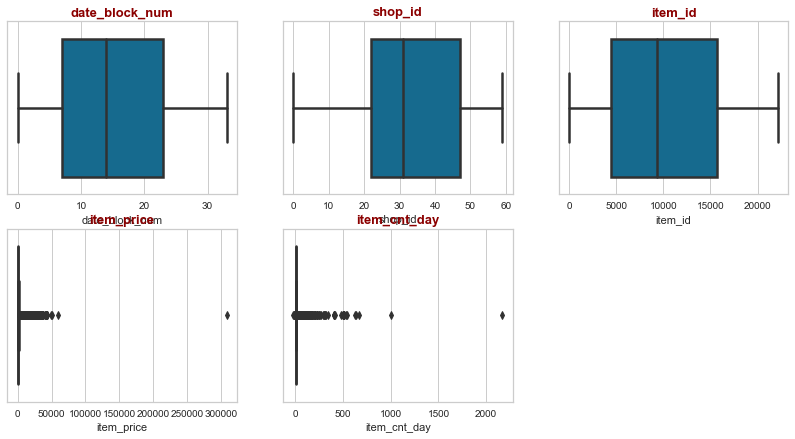

In [13]:
# Checking for df1
plt.figure(figsize=(14,7))
col_names= ['date_block_num', 'shop_id', 'item_id', 'item_price',
            'item_cnt_day']

for i in range(5):
    plt.subplot(2,3,i+1)
    ax= sns.boxplot(x= df_train[col_names[i]], linewidth=2.5)
    plt.title(col_names[i], fontdict=title_font)    #There are some outliers for item_price and item_cnt_day columns. 
plt.show()

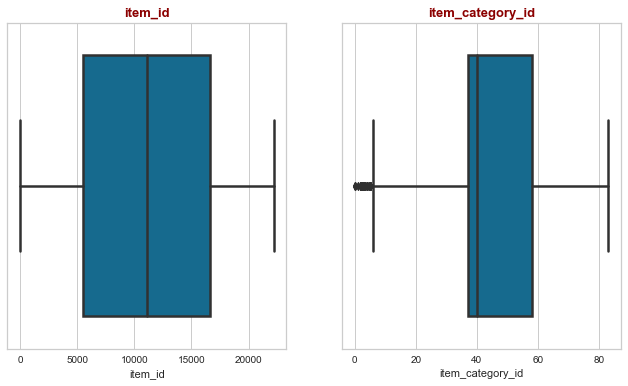

In [14]:
# Checking for df2
plt.figure(figsize=(11,6))
col_names= ['item_id', 'item_category_id']

for i in range(2):
    plt.subplot(1,2,i+1)
    ax= sns.boxplot(x= df_item[col_names[i]], linewidth=2.5)
    plt.title(col_names[i], fontdict=title_font)  
plt.show()

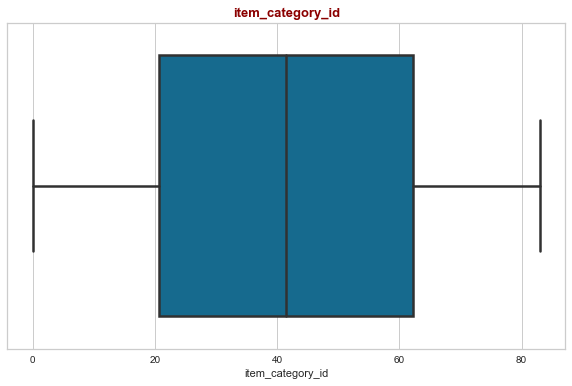

In [15]:
plt.figure(figsize=(10,6))
ax= sns.boxplot(x=df_category["item_category_id"], linewidth=2.5)
plt.title("item_category_id", fontdict=title_font)
plt.show()

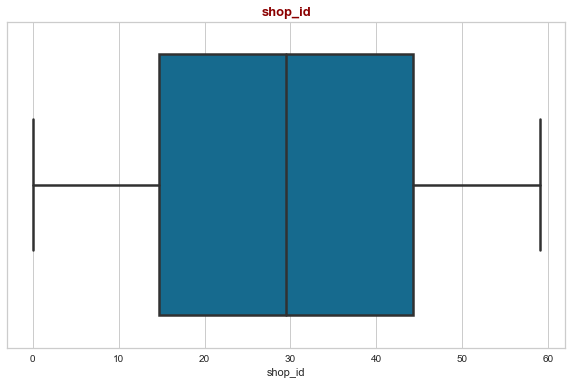

In [16]:
plt.figure(figsize=(10,6))
ax= sns.boxplot(x=df_shop["shop_id"], linewidth=2.5)
plt.title("shop_id", fontdict=title_font)
plt.show()

2.2- We will get rid of outliers.

Trying winsorization to get rid of outliers.

In [17]:
df_train["win_item_price"]= winsorize(df_train["item_price"], (0,0.10))
df_train["win_item_cnt_day"]= winsorize(df_train["item_cnt_day"], (0,0.10))

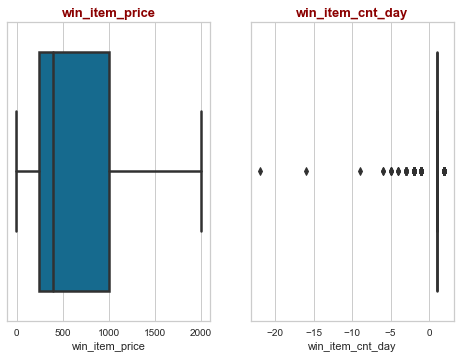

In [18]:
plt.subplot(121)
ax= sns.boxplot(x=df_train["win_item_price"], linewidth=2.5)
plt.title("win_item_price", fontdict=title_font)

plt.subplot(122)
ax= sns.boxplot(x=df_train["win_item_cnt_day"], linewidth=2.5)
plt.title("win_item_cnt_day", fontdict=title_font)
plt.show()  #Nice! There is not appears any outliers by winsorization in win_item_price. 

Trying logarithmic transformation.

In [19]:
df_train["log_item_cnt_day"]= np.log(df_train["item_cnt_day"])

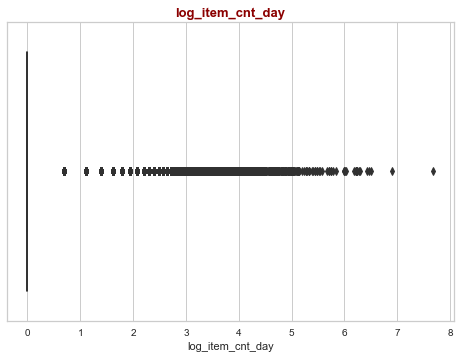

In [20]:
ax= sns.boxplot(x=df_train["log_item_cnt_day"])
plt.title("log_item_cnt_day", fontdict=title_font)
plt.show()  # We tried log transformation but we can't get rid of outlier on item_cnt_day. 

In [21]:
df_train= df_train.drop(df_train[df_train["item_price"]>3000].index)  #We droped the outliers
df_train= df_train.drop(df_train[df_train["item_cnt_day"]>2000].index)

In [22]:
df_train[(df_train["item_price"]>3000)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,win_item_price,win_item_cnt_day,log_item_cnt_day


In [23]:
df_train[(df_train["item_cnt_day"]>2000)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,win_item_price,win_item_cnt_day,log_item_cnt_day


In [24]:
del df_train["win_item_price"]  
del df_train["win_item_cnt_day"]
del df_train["log_item_cnt_day"]

### 3- Exploratory Data Analysis

#### 3.1- Firts of all we will combine and prepare all datas. 

In [25]:
df_train= pd.merge(df_train, df_item, on="item_id", how="inner")
df_train= pd.merge(df_train, df_category, on="item_category_id", how="inner")
df_train= pd.merge(df_train, df_shop, on="shop_id", how="inner")
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,26.04.2013,3,59,944,150.0,1.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
2,26.06.2013,5,59,944,199.5,1.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
3,20.07.2013,6,59,944,199.5,1.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
4,14.09.2013,8,59,944,299.0,2.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""


In [26]:
pd.options.display.float_format= "{:.6f}".format
df_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2844998.000000,2844998.000000,2844998.000000,2844998.000000,2844998.000000,2844998.000000
mean,14.399116,33.058007,10285.417777,685.869920,1.236586,40.457104
std,9.379990,16.231240,6349.007104,669.636790,2.267150,16.681681
min,0.000000,0.000000,0.000000,-1.000000,-22.000000,0.000000
25%,6.000000,22.000000,4479.000000,249.000000,1.000000,30.000000
50%,13.000000,31.000000,9512.000000,399.000000,1.000000,40.000000
75%,22.000000,47.000000,15834.000000,899.000000,1.000000,55.000000
max,33.000000,59.000000,22168.000000,3000.000000,1000.000000,83.000000


Our values are in Russian. We will translate into English.

In [27]:
dict_categories = ['Cinema - DVD', 'PC Games - Standard Editions',
                    'Music - Local Production CD', 'Games - PS3', 'Cinema - Blu-Ray',
                    'Games - XBOX 360', 'PC Games - Additional Editions', 'Games - PS4',
                    'Gifts - Stuffed Toys', 'Gifts - Board Games (Compact)',
                    'Gifts - Figures', 'Cinema - Blu-Ray 3D',
                    'Programs - Home and Office', 'Gifts - Development',
                    'Gifts - Board Games', 'Gifts - Souvenirs (on the hinge)',
                    'Cinema - Collection', 'Music - MP3', 'Games - PSP',
                    'Gifts - Bags, Albums, Mouse Pads', 'Gifts - Souvenirs',
                    'Books - Audiobooks', 'Gifts - Gadgets, robots, sports',
                    'Accessories - PS4', 'Games - PSVita',
                    'Books - Methodical materials 1C', 'Payment cards - PSN',
                    'PC Games - Digit', 'Games - Game Accessories', 'Accessories - XBOX 360',
                    'Accessories - PS3', 'Games - XBOX ONE', 'Music - Vinyl',
                    'Programs - 1C: Enterprise 8', 'PC Games - Collectible Editions',
                    'Gifts - Attributes', 'Service Tools',
                    'Music - branded production CD', 'Payment cards - Live!',
                    'Game consoles - PS4', 'Accessories - PSVita', 'Batteries',
                    'Music - Music Video', 'Game Consoles - PS3',
                    'Books - Comics, Manga', 'Game Consoles - XBOX 360',
                    'Books - Audiobooks 1C', 'Books - Digit',
                    'Payment cards (Cinema, Music, Games)', 'Gifts - Cards, stickers',
                    'Accessories - XBOX ONE', 'Pure media (piece)',
                    'Programs - Home and Office (Digital)', 'Programs - Educational',
                    'Game consoles - PSVita', 'Books - Artbooks, encyclopedias',
                    'Programs - Educational (Digit)', 'Accessories - PSP',
                    'Gaming consoles - XBOX ONE', 'Delivery of goods',
                    'Payment Cards - Live! (Figure) ',' Tickets (Figure) ',
                    'Music - Gift Edition', 'Service Tools - Tickets',
                    'Net media (spire)', 'Cinema - Blu-Ray 4K', 'Game consoles - PSP',
                    'Game Consoles - Others', 'Books - Audiobooks (Figure)',
                    'Gifts - Certificates, Services', 'Android Games - Digit',
                    'Programs - MAC (Digit)', 'Payment Cards - Windows (Digit)',
                    'Books - Business Literature', 'Games - PS2', 'MAC Games - Digit',
                    'Books - Computer Literature', 'Books - Travel Guides',
                    'PC - Headsets / Headphones', 'Books - Fiction',
                    'Books - Cards', 'Accessories - PS2', 'Game consoles - PS2',
                    'Books - Cognitive literature']
dict_shops = ['Moscow Shopping Center "Semenovskiy"', 
              'Moscow TRK "Atrium"', 
              "Khimki Shopping Center",
              'Moscow TC "MEGA Teply Stan" II', 
              'Yakutsk Ordzhonikidze, 56',
              'St. Petersburg TC "Nevsky Center"', 
              'Moscow TC "MEGA Belaya Dacha II"',
              'Voronezh (Plekhanovskaya, 13)', 
              'Yakutsk Shopping Center "Central"',
              'Chekhov SEC "Carnival"', 
              'Sergiev Posad TC "7Ya"',
              'Tyumen TC "Goodwin"',
              'Kursk TC "Pushkinsky"', 
              'Kaluga SEC "XXI Century"',
              'N.Novgorod Science and entertainment complex "Fantastic"',
              'Moscow MTRC "Afi Mall"',
              'Voronezh SEC "Maksimir"', 'Surgut SEC "City Mall"',
              'Moscow Shopping Center "Areal" (Belyaevo)', 'Krasnoyarsk Shopping Center "June"',
              'Moscow TK "Budenovsky" (pav.K7)', 'Ufa "Family" 2',
              'Kolomna Shopping Center "Rio"', 'Moscow Shopping Center "Perlovsky"',
              'Moscow Shopping Center "New Century" (Novokosino)', 'Omsk Shopping Center "Mega"',
              'Moscow Shop C21', 'Tyumen Shopping Center "Green Coast"',
              'Ufa TC "Central"', 'Yaroslavl shopping center "Altair"',
              'RostovNaDonu "Mega" Shopping Center', '"Novosibirsk Mega "Shopping Center',
              'Samara Shopping Center "Melody"', 'St. Petersburg TC "Sennaya"',
              "Volzhsky Shopping Center 'Volga Mall' ",
              'Vologda Mall "Marmelad"', 'Kazan TC "ParkHouse" II',
              'Samara Shopping Center ParkHouse', '1C-Online Digital Warehouse',
              'Online store of emergencies', 'Adygea Shopping Center "Mega"',
              'Balashikha shopping center "October-Kinomir"' , 'Krasnoyarsk Shopping center "Vzletka Plaza" ',
              'Tomsk SEC "Emerald City"', 'Zhukovsky st. Chkalov 39m? ',
              'Kazan Shopping Center "Behetle"', 'Tyumen SEC "Crystal"',
              'RostovNaDonu TRK "Megacenter Horizon"',
              '! Yakutsk Ordzhonikidze, 56 fran', 'Moscow TC "Silver House"',
              'Moscow TK "Budenovsky" (pav.A2)', "N.Novgorod SEC 'RIO' ",
              '! Yakutsk TTS "Central" fran', 'Mytishchi TRK "XL-3"',
              'RostovNaDonu TRK "Megatsentr Horizon" Ostrovnoy', 'Exit Trade',
              'Voronezh SEC City-Park "Grad"', "Moscow 'Sale'",
              'Zhukovsky st. Chkalov 39m² ',' Novosibirsk Shopping Mall "Gallery Novosibirsk"']


In [28]:
df_train["item_category_name"]= df_train["item_category_name"].map(
         dict(zip(df_train["item_category_name"].value_counts().index, dict_categories)))
df_train["shop_name"]= df_train["shop_name"].map(
         dict(zip(df_train["shop_name"].value_counts().index, dict_shops)))

We will prepare the date column to pandas datetime.

In [29]:
df_train["date"]= pd.to_datetime(df_train["date"], format="%d.%m.%Y")
df_train["month"]= df_train["date"].dt.month
df_train["day"]= df_train["date"].dt.day
df_train["year"]= df_train["date"].dt.year
df_train.head(20)  #Seems nice!

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,month,day,year
0,2013-01-02,0,59,22154,999.000000,1.000000,ЯВЛЕНИЕ 2012 (BD),37,Cinema - Blu-Ray,"Yaroslavl shopping center ""Altair""",1,2,2013
1,2013-04-26,3,59,944,150.000000,1.000000,2012 (BD),37,Cinema - Blu-Ray,"Yaroslavl shopping center ""Altair""",4,26,2013
2,2013-06-26,5,59,944,199.500000,1.000000,2012 (BD),37,Cinema - Blu-Ray,"Yaroslavl shopping center ""Altair""",6,26,2013
3,2013-07-20,6,59,944,199.500000,1.000000,2012 (BD),37,Cinema - Blu-Ray,"Yaroslavl shopping center ""Altair""",7,20,2013
4,2013-09-14,8,59,944,299.000000,2.000000,2012 (BD),37,Cinema - Blu-Ray,"Yaroslavl shopping center ""Altair""",9,14,2013
5,2013-10-21,9,59,944,299.000000,1.000000,2012 (BD),37,Cinema - Blu-Ray,"Yaroslavl shopping center ""Altair""",10,21,2013
6,2013-11-02,10,59,944,299.000000,1.000000,2012 (BD),37,Cinema - Blu-Ray,"Yaroslavl shopping center ""Altair""",11,2,2013
7,2014-01-06,12,59,944,299.000000,1.000000,2012 (BD),37,Cinema - Blu-Ray,"Yaroslavl shopping center ""Altair""",1,6,2014
8,2014-03-30,14,59,944,299.000000,1.000000,2012 (BD),37,Cinema - Blu-Ray,"Yaroslavl shopping center ""Altair""",3,30,2014
9,2014-04-20,15,59,944,199.000000,1.000000,2012 (BD),37,Cinema - Blu-Ray,"Yaroslavl shopping center ""Altair""",4,20,2014


#### 3.2- Explore Of Data

We examine correlation between features. 

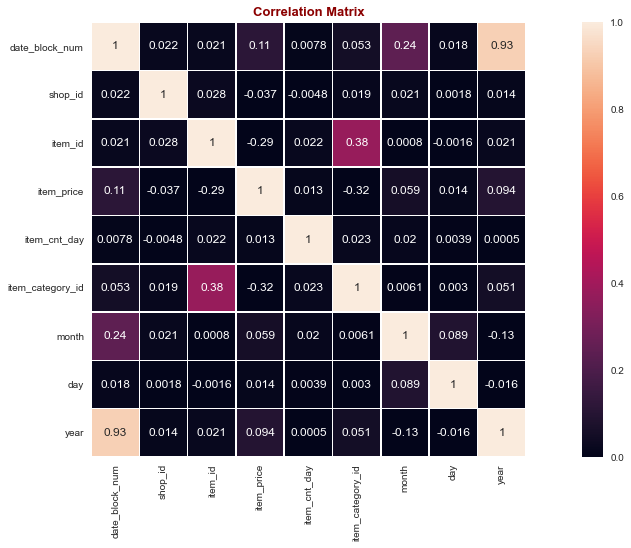

In [30]:
correlation_matrix= df_train.corr()
plt.figure(figsize=(20,8))
sns.heatmap(correlation_matrix, square=True, annot=True, vmin=0, vmax=1, linewidth=0.5)
plt.title("Correlation Matrix", fontdict=title_font)
plt.show()

Let's do comparison between the most valuable shops and most profitable shops. 

In [31]:
df_train["total_revenue"]= df_train["item_price"]*df_train["item_cnt_day"]

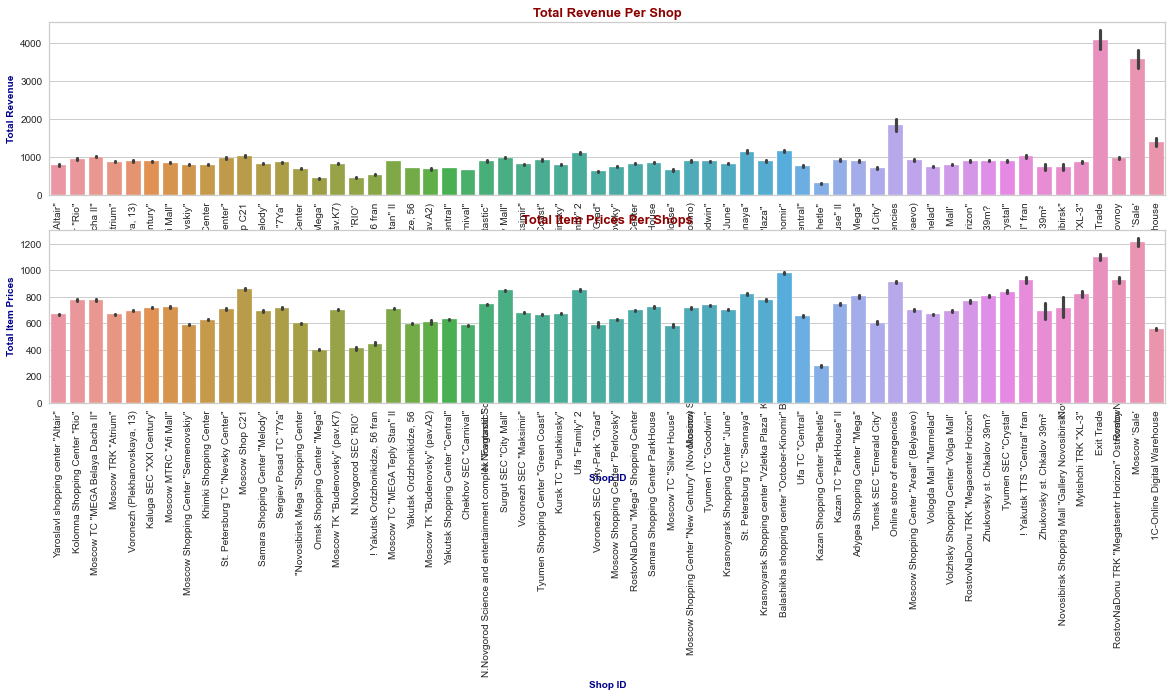

In [32]:
plt.figure(figsize=(20,7))
plt.subplot(211)
sns.barplot(data=df_train, x="shop_name", y="total_revenue")
plt.xticks(rotation=90)
plt.title("Total Revenue Per Shop", fontdict=title_font)
plt.xlabel("Shop ID", fontdict=label_font)
plt.ylabel("Total Revenue", fontdict=label_font)

plt.subplot(212)
sns.barplot(data=df_train, x="shop_name", y="item_price")
plt.xticks(rotation=90)
plt.title("Total Item Prices Per Shops", fontdict=title_font)
plt.xlabel("Shop ID", fontdict=label_font)
plt.ylabel("Total Item Prices", fontdict=label_font)
plt.show()

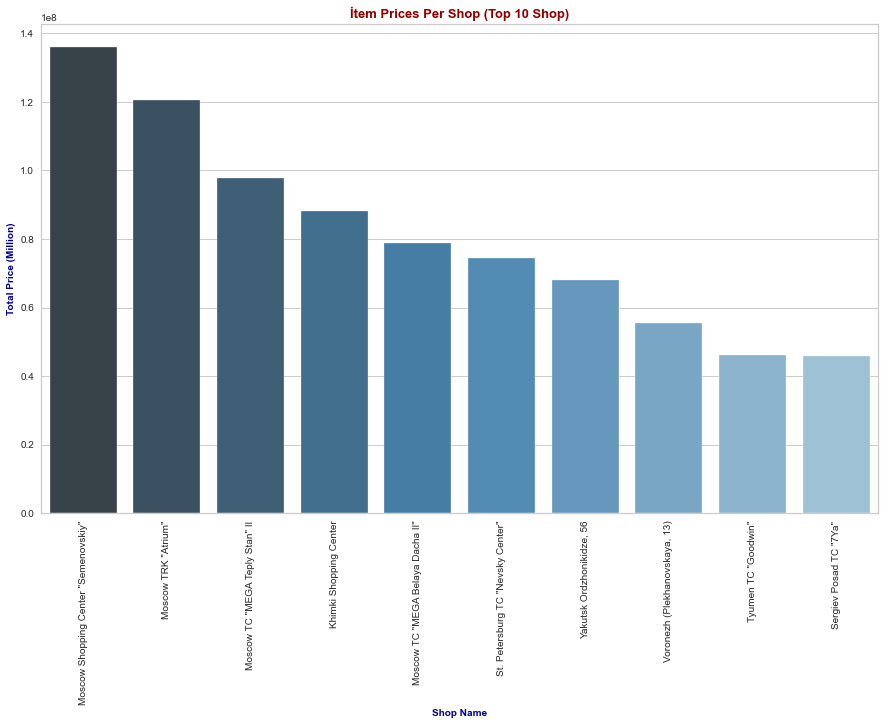

In [33]:
df_price= pd.DataFrame(df_train.groupby("shop_name")["item_price"].sum().nlargest(10))
df_revenue= pd.DataFrame(df_train.groupby("shop_name")["total_revenue"].sum().nlargest(10))

plt.figure(figsize=(15,9))
sns.barplot(df_price.index, df_price["item_price"].nlargest(10), palette="Blues_d")
plt.xticks(rotation=90)
plt.title("İtem Prices Per Shop (Top 10 Shop)", fontdict=title_font)
plt.xlabel("Shop Name", fontdict=label_font)
plt.ylabel("Total Price (Million)", fontdict=label_font)
plt.show()



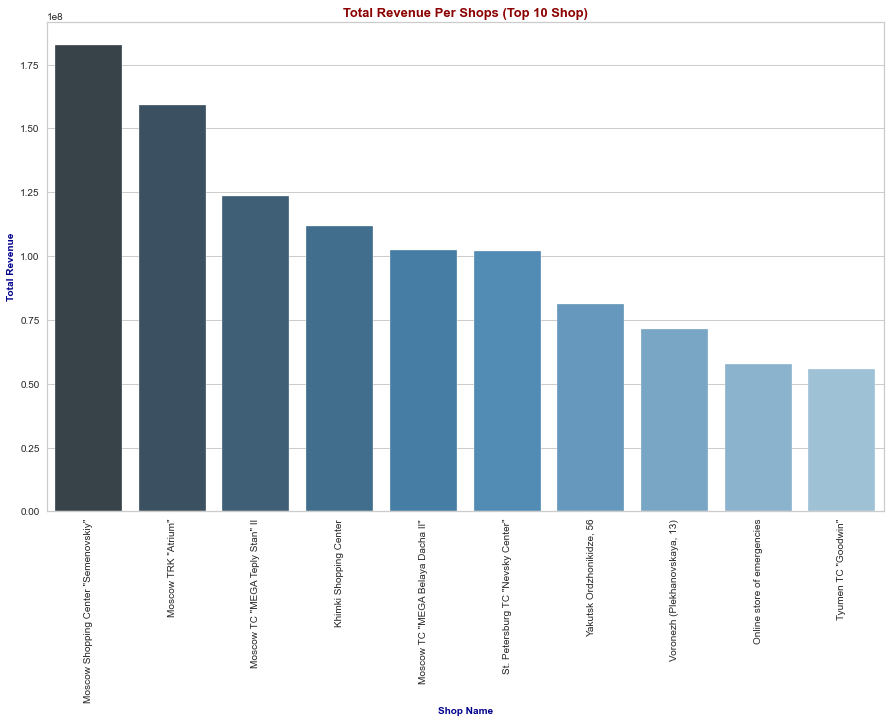

In [34]:
plt.figure(figsize=(15,9))
sns.barplot(df_revenue.index, df_revenue["total_revenue"].nlargest(10), palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Total Revenue Per Shops (Top 10 Shop)", fontdict=title_font)
plt.xlabel("Shop Name", fontdict=label_font)
plt.ylabel("Total Revenue", fontdict=label_font)
plt.show()


When we look plots, there is some differences between total item valuability and total profit. 

Now, we will try to examine sales by the time.

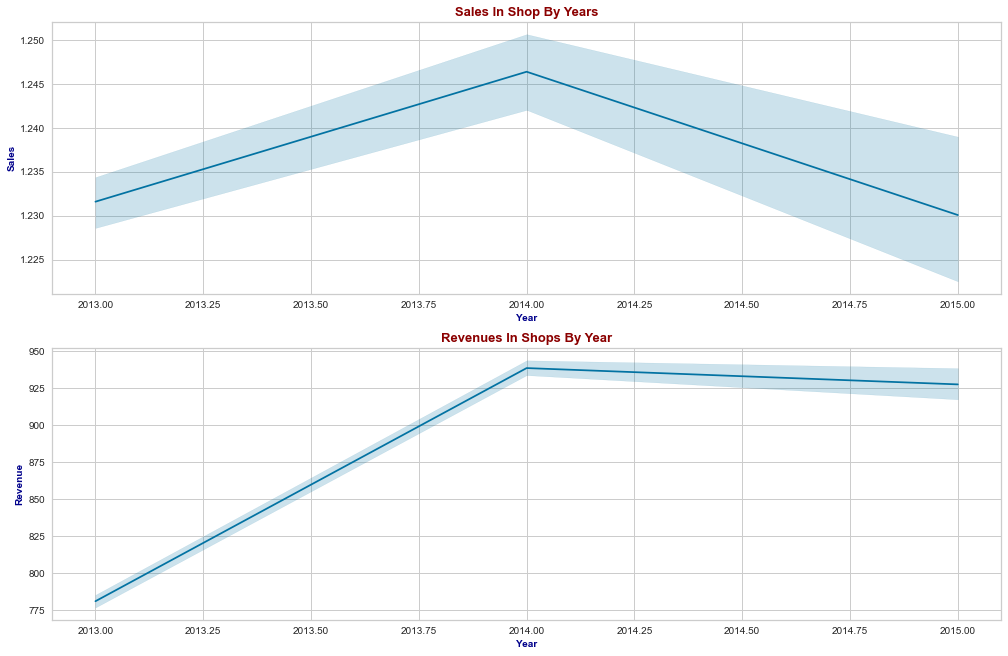

In [35]:
plt.figure(figsize=(17,11))
plt.subplot(211)
sns.lineplot(data=df_train, x="year", y="item_cnt_day")
plt.title("Sales In Shop By Years", fontdict=title_font)
plt.xlabel("Year", fontdict=label_font)
plt.ylabel("Sales", fontdict=label_font)

plt.subplot(212)
sns.lineplot(data=df_train, x="year", y="total_revenue")
plt.title("Revenues In Shops By Year", fontdict=title_font)
plt.xlabel("Year", fontdict=label_font)
plt.ylabel("Revenue", fontdict=label_font)
plt.show()

- Sales increased until 2014, however after 2014 that was decreased.
- Profits increased all the time. 

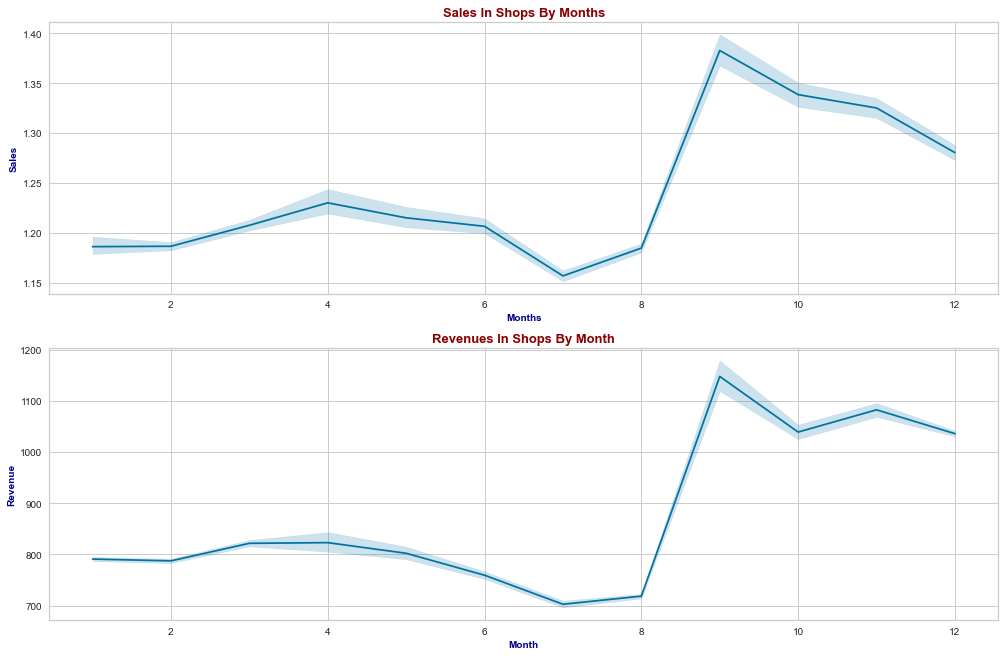

In [36]:
plt.figure(figsize=(17,11))
plt.subplot(211)
sns.lineplot(data=df_train, x="month", y="item_cnt_day")
plt.title("Sales In Shops By Months", fontdict=title_font)
plt.xlabel("Months", fontdict=label_font)
plt.ylabel("Sales", fontdict=label_font)

plt.subplot(212)
sns.lineplot(data=df_train, x="month", y="total_revenue")
plt.title("Revenues In Shops By Month", fontdict=title_font)
plt.xlabel("Month", fontdict=label_font)
plt.ylabel("Revenue", fontdict=label_font)
plt.show()

The highest sales in year are in 9, 10, 11. months. But, the most total profit are in 11. and 12. month.

Let's examine Which products are sold the most.

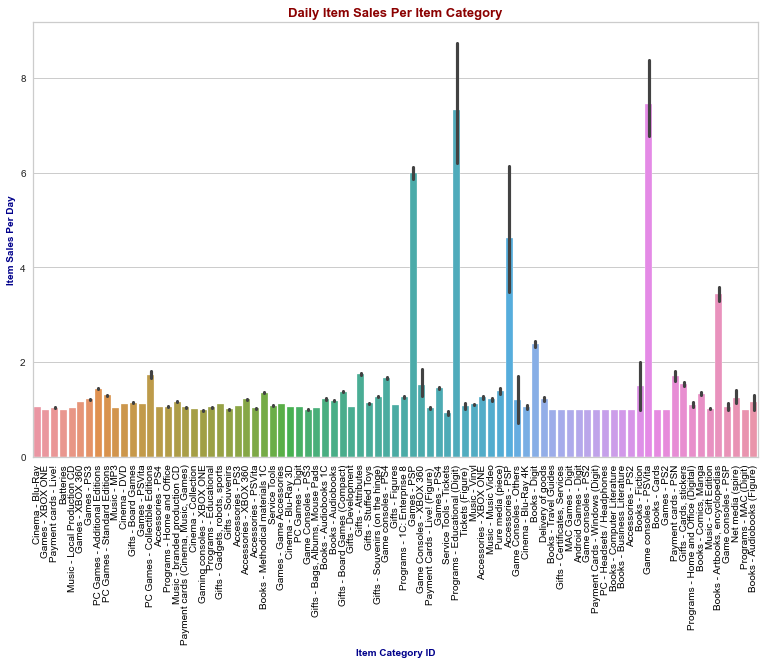

In [37]:
plt.figure(figsize=(13,8))
sns.barplot(data=df_train, x="item_category_name", y="item_cnt_day", )
plt.xticks(rotation=90, color="black")  
plt.title("Daily Item Sales Per Item Category", fontdict=title_font)
plt.xlabel("Item Category ID", fontdict=label_font)
plt.ylabel("Item Sales Per Day", fontdict=label_font)
plt.show()

Some items come to the fore in sales.

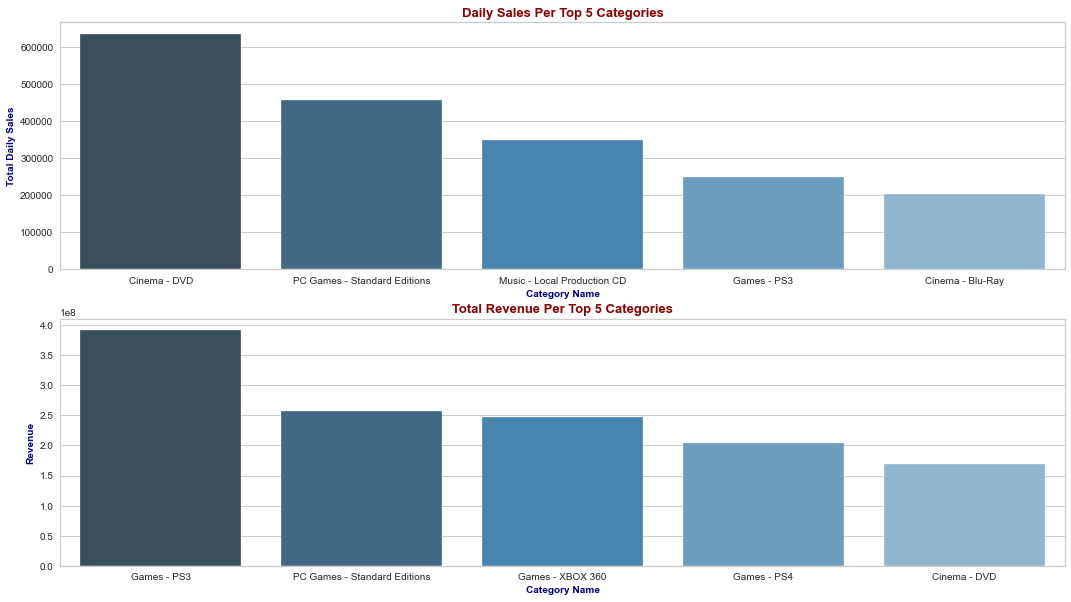

In [38]:
df_cnt= pd.DataFrame(df_train.groupby("item_category_name")["item_cnt_day"].sum().nlargest(5))
df_rvn= pd.DataFrame(df_train.groupby("item_category_name")["total_revenue"].sum().nlargest(5))

plt.figure(figsize=(18,10))
plt.subplot(211)
sns.barplot(df_cnt.index, df_cnt["item_cnt_day"].nlargest(5), palette="Blues_d")
plt.title("Daily Sales Per Top 5 Categories", fontdict=title_font)
plt.xlabel("Category Name", fontdict=label_font)
plt.ylabel("Total Daily Sales", fontdict=label_font)

plt.subplot(212)
sns.barplot(df_rvn.index, df_rvn["total_revenue"], palette="Blues_d")
plt.title("Total Revenue Per Top 5 Categories", fontdict=title_font)
plt.xlabel("Category Name", fontdict=label_font)
plt.ylabel("Revenue", fontdict=label_font)
plt.show()

There are some differences between top category sales and top category profits. 

In [39]:
df_train["year-month"]= pd.to_datetime(df_train["date"]).dt.to_period("M")
df_train.head()   #We created new column as "year-month" in df_train for making easy the grouping.

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,month,day,year,total_revenue,year-month
0,2013-01-02,0,59,22154,999.000000,1.000000,ЯВЛЕНИЕ 2012 (BD),37,Cinema - Blu-Ray,"Yaroslavl shopping center ""Altair""",1,2,2013,999.000000,2013-01
1,2013-04-26,3,59,944,150.000000,1.000000,2012 (BD),37,Cinema - Blu-Ray,"Yaroslavl shopping center ""Altair""",4,26,2013,150.000000,2013-04
2,2013-06-26,5,59,944,199.500000,1.000000,2012 (BD),37,Cinema - Blu-Ray,"Yaroslavl shopping center ""Altair""",6,26,2013,199.500000,2013-06
3,2013-07-20,6,59,944,199.500000,1.000000,2012 (BD),37,Cinema - Blu-Ray,"Yaroslavl shopping center ""Altair""",7,20,2013,199.500000,2013-07
4,2013-09-14,8,59,944,299.000000,2.000000,2012 (BD),37,Cinema - Blu-Ray,"Yaroslavl shopping center ""Altair""",9,14,2013,598.000000,2013-09


Creating a new column which name is season.

In [40]:
conditions= [(df_train["month"]==3) | (df_train["month"]==4) | (df_train["month"]==5),
             (df_train["month"]==6) | (df_train["month"]==7) | (df_train["month"]==8),
             (df_train["month"]==9) | (df_train["month"]==10) | (df_train["month"]==11),
             (df_train["month"]==12) | (df_train["month"]==1) | (df_train["month"]==2)]
choices= ["spring", "summer", "autumn", "winter"]
df_train["season"]= np.select(conditions, choices)
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,month,day,year,total_revenue,year-month,season
0,2013-01-02,0,59,22154,999.000000,1.000000,ЯВЛЕНИЕ 2012 (BD),37,Cinema - Blu-Ray,"Yaroslavl shopping center ""Altair""",1,2,2013,999.000000,2013-01,winter
1,2013-04-26,3,59,944,150.000000,1.000000,2012 (BD),37,Cinema - Blu-Ray,"Yaroslavl shopping center ""Altair""",4,26,2013,150.000000,2013-04,spring
2,2013-06-26,5,59,944,199.500000,1.000000,2012 (BD),37,Cinema - Blu-Ray,"Yaroslavl shopping center ""Altair""",6,26,2013,199.500000,2013-06,summer
3,2013-07-20,6,59,944,199.500000,1.000000,2012 (BD),37,Cinema - Blu-Ray,"Yaroslavl shopping center ""Altair""",7,20,2013,199.500000,2013-07,summer
4,2013-09-14,8,59,944,299.000000,2.000000,2012 (BD),37,Cinema - Blu-Ray,"Yaroslavl shopping center ""Altair""",9,14,2013,598.000000,2013-09,autumn


We will examine the sales according to seasons.

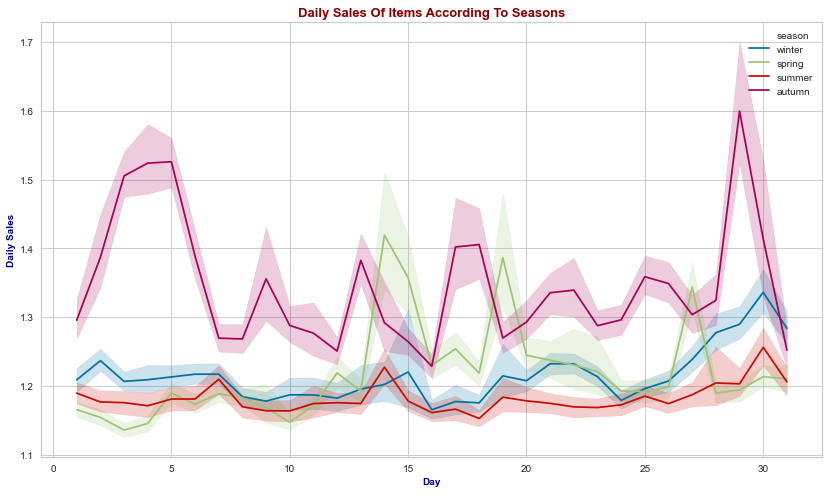

In [41]:
plt.figure(figsize=(14,8))
sns.lineplot(data=df_train, x="day", y="item_cnt_day", hue="season")
plt.title("Daily Sales Of Items According To Seasons", fontdict=title_font)
plt.xlabel("Day", fontdict=label_font)
plt.ylabel("Daily Sales", fontdict=label_font)
plt.show()

This plot shows us that sales increased in the spring at the end of the month.

In [42]:
#We will use "df" DataFrame for apply model.
df = pd.DataFrame(df_train.groupby(["date_block_num","item_id", "shop_id", "year-month", "item_price", "total_revenue",
                                    "month", "day", "year", "season"]).item_cnt_day.sum())
df= df.reset_index().sort_values(by="year-month", ascending=True)
df= pd.concat([df, pd.get_dummies(df["season"], prefix="season", prefix_sep="_")], axis=1)
del df["year-month"]
del df["season"]
df.head()

,date_block_num,item_id,shop_id,item_price,total_revenue,month,day,year,item_cnt_day,season_autumn,season_spring,season_summer,season_winter
0,0,19,25,28.000000,28.000000,1,12,2013,1.000000,0,0,0,1
75931,0,13890,27,349.000000,349.000000,1,24,2013,1.000000,0,0,0,1
75930,0,13890,27,349.000000,349.000000,1,18,2013,1.000000,0,0,0,1
75929,0,13890,27,349.000000,349.000000,1,2,2013,1.000000,0,0,0,1
75928,0,13890,27,349.000000,349.000000,1,1,2013,1.000000,0,0,0,1


### 4- Clustering The Data With MiniBatchK-Means

Before clustering we will make standardization.

In [43]:
scaler= MinMaxScaler(feature_range=(-1,1))
X= scaler.fit_transform(df)

Deciding the optimum K kalue by using the elbow method.

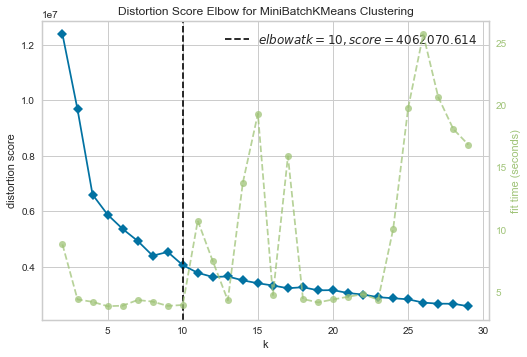

In [44]:
clusterer= MiniBatchKMeans(random_state=123).fit(X)
visu= KElbowVisualizer(clusterer,k=(2,30)).fit(X)
visu.poof()

As we see the optimum K value is 10. <br/>
We will prepare the optimum clustering model eventually. 

In [44]:
clusterer= MiniBatchKMeans(n_clusters=10, random_state=123, batch_size=100000, verbose=0).fit(X)

#### Applying PCA

We wiil plot the distribution of clusters. We have to apply PCA for showing the data in 2 dimension before plotting. <br/> Explained variance ratio is not high for 2 dimension. We will check the optimum dimension value. 

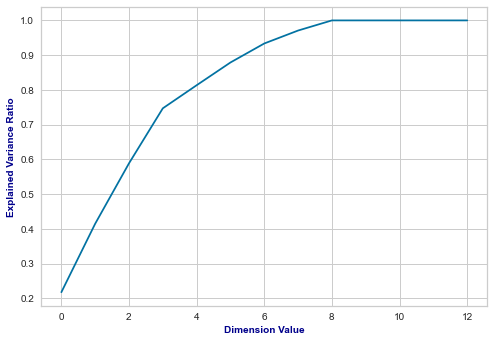

In [46]:
pca= PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_));
plt.xlabel("Dimension Value", fontdict=label_font)
plt.ylabel("Explained Variance Ratio", fontdict=label_font)
plt.show()

If we want to reduce the dimension, we should set the optimum dimension value to 7. <br/> However, we will plot the PCA in 2 dimension for visualization the data.

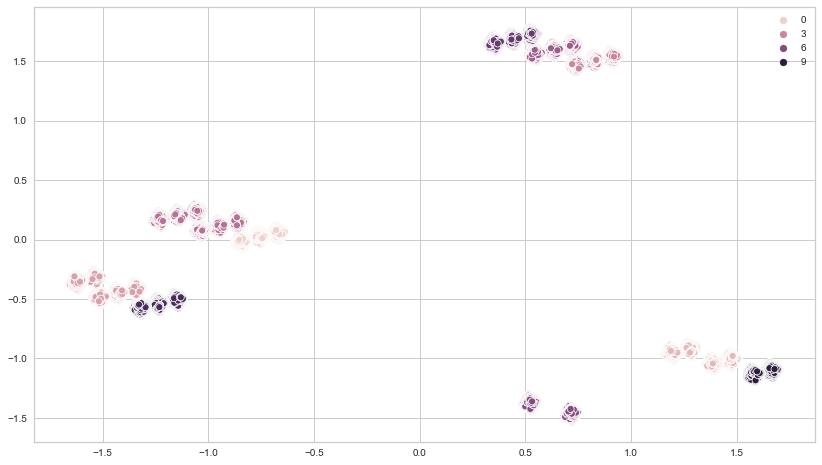

In [47]:
pca_2= PCA(n_components=2)
pca= pca_2.fit_transform(X)
df_pca= pd.DataFrame(pca, columns={"D_1", "D_2"})

plt.figure(figsize=(14,8))
sns.scatterplot(x=pca[:,0], y=pca[:,1], hue=clusterer.labels_)
plt.show()

So, the shown above is the distribution of data on 2 dimensional. 

Now, we will add the cluster labels to dataFrame

In [45]:
df["cluster"]= clusterer.labels_
df.head()

,date_block_num,item_id,shop_id,item_price,total_revenue,month,day,year,item_cnt_day,season_autumn,season_spring,season_summer,season_winter,cluster
0,0,19,25,28.000000,28.000000,1,12,2013,1.000000,0,0,0,1,9
75931,0,13890,27,349.000000,349.000000,1,24,2013,1.000000,0,0,0,1,9
75930,0,13890,27,349.000000,349.000000,1,18,2013,1.000000,0,0,0,1,9
75929,0,13890,27,349.000000,349.000000,1,2,2013,1.000000,0,0,0,1,9
75928,0,13890,27,349.000000,349.000000,1,1,2013,1.000000,0,0,0,1,9


### 5- Applying XGBoost

In [49]:
#We are setting the features before applying XGBoost.
X= df.drop(["item_cnt_day"], axis=1)
y=df["item_cnt_day"]
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=123)

Applying the model

In [50]:
start_time= time.time()
df_xg= xgb.XGBRegressor(objective="reg:linear", seed=123)
df_xg.fit(X_train, y_train)
print("--- %s Second ---"% (time.time() - start_time))
pred= df_xg.predict(X_test)

[13:57:48] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:58:51] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
--- 64.08650803565979 Second ---


Let's look at which features has effecitve on the model.

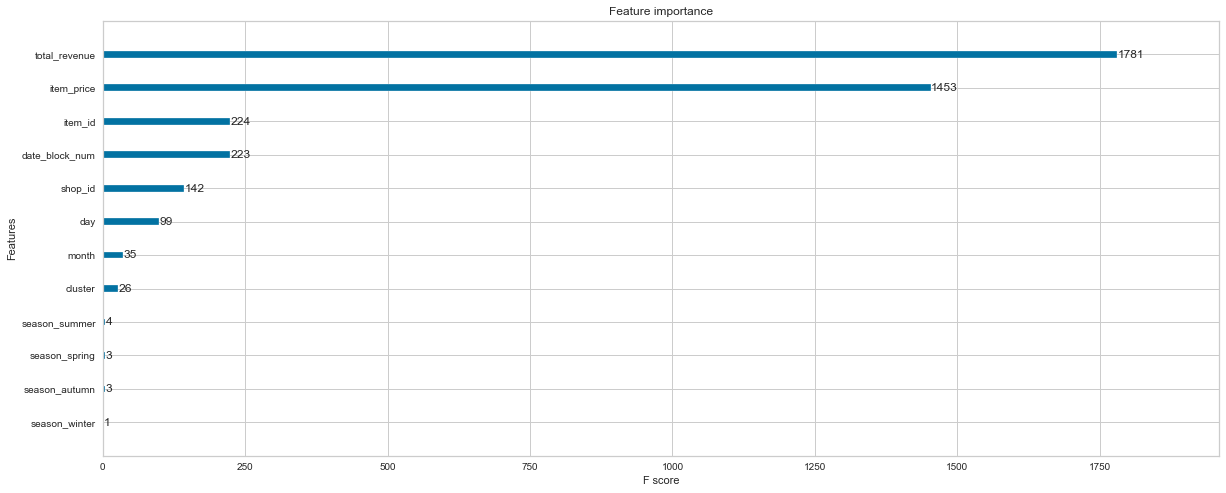

In [51]:
ax= xgb.plot_importance(df_xg)
ax.figure.set_size_inches(20,8)
plt.show()

Evaluation Of Model Performance

In [52]:
print("MSE: {}".format(mse(y_test, pred)))
print("RMSE: {}".format(np.sqrt(mse(y_test, pred))))
print("MAE: {}".format(mean_absolute_error(y_test, pred)))

MSE: 0.436199195289997
RMSE: 0.6604537798286849
MAE: 0.007838459950903487


Cross Validation Of Model

In [53]:
#Before cross validation we should transform data to DMatrix format.
df_xg= xgb.DMatrix(data=X, label=y)
params= {"objective": "reg:linear", "max_depth":5, "silent":1}
df_xg_cv= xgb.cv(dtrain=df_xg, num_boost_round=100, early_stopping_rounds=5, params=params, metrics="rmse", as_pandas=True)
display(df_xg_cv.sort_values(by="test-rmse-mean").head())

[14:05:30] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:05:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:05:31] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:05:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
99,0.062578,0.001420,0.418343,0.200753
98,0.062915,0.001617,0.418426,0.200767
97,0.064248,0.002669,0.418773,0.200500
96,0.064576,0.002361,0.418902,0.200449
95,0.065045,0.002617,0.419176,0.200292


Hyperparameter Tuning Of Model

In [54]:
#Tuning with GridSearch 
param_grid= {"penalty": ["l1", "l2"],
         "C": [10**x for x in np.arange(1,5,1)],
         "max_depth": [3,4,5],
         "learning_rate": [0.1, 0.2, 0.3]
          }
df_grid= xgb.XGBRegressor(objective="reg:linear", seed=123) 
model_grid= GridSearchCV(estimator=df_grid, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
model_grid.fit(X_train,y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 31.7min finished


[15:07:41] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:07:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { penalty } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:08:36] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None,
                                    objective='reg:linear', random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, seed=123,
             

Results:

In [63]:
results= model_grid.cv_results_
df_cv= pd.DataFrame(results)
df_cv= df_cv[["param_C", "param_learning_rate", "param_max_depth", "param_penalty", "mean_test_score"]]
df_cv= df_cv.sort_values(by="mean_test_score", ascending=False)
df_cv.head()

,param_penalty,mean_test_score
0,l1,0.972376
1,l2,0.972376


In [64]:
print("Best Score: {}".format(model_grid.best_score_))
model_grid.best_params_

Best Score: 0.9723761907633838


{'penalty': 'l1'}

Selecting alpha value for l1 regularization.

In [74]:
model= xgb.DMatrix(data=X, label=y)
l1_alphas= np.arange(0,3,0.5)
rmses_l1= []
params= {"objective": "reg:squarederror", "learning_rate": 0.2, "max_depth":3}
for alpha in l1_alphas:
    params["alpha"]=alpha
    cv_rmse=xgb.cv(dtrain=model, params=params, num_boost_round=100, metrics="rmse",
                   early_stopping_rounds=10, as_pandas=True, seed=123)
    rmses_l1.append(cv_rmse["test-rmse-mean"].tail(1).values[0])
print("Best L1 Values: ")
best_params= pd.DataFrame(list(zip(l1_alphas, rmses_l1)), columns=["l1", "rmse"])
display(best_params.sort_values("rmse"))

[20:55:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { C } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:55:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { C } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:55:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { C } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verificat

,l1,rmse
1,0.5,0.447131
0,0.0,0.452737
3,1.5,0.455326
2,1.0,0.458077
4,2.0,0.463878
5,2.5,0.467083


As we see the best alpha value is  0.5 <br/> Optimum Version Of Model: 

In [75]:
model= xgb.XGBRegressor(objective="reg:squarederror", seed=123, learning_rate=0.2,
                        max_depth=3, alpha=0.5)
start= time.time()
model.fit(X_train, y_train)
print("--- Second %s---" %(time.time()- start))
y_pred= model.predict(X_test)

--- Second 28.6405930519104---


In [76]:
print("RMSE: {}".format(np.sqrt(mse(y_test, y_pred))))

RMSE: 0.2687686421375984


### 6- Applying RNN Model

Preparing the data before RNN

In [79]:
df.head()

,date_block_num,item_id,shop_id,item_price,total_revenue,month,day,year,item_cnt_day,season_autumn,season_spring,season_summer,season_winter,cluster
0,0,19,25,28.000000,28.000000,1,12,2013,1.000000,0,0,0,1,9
75931,0,13890,27,349.000000,349.000000,1,24,2013,1.000000,0,0,0,1,9
75930,0,13890,27,349.000000,349.000000,1,18,2013,1.000000,0,0,0,1,9
75929,0,13890,27,349.000000,349.000000,1,2,2013,1.000000,0,0,0,1,9
75928,0,13890,27,349.000000,349.000000,1,1,2013,1.000000,0,0,0,1,9


In [81]:
X= df.drop(["item_cnt_day"], axis=1)
y= df["item_cnt_day"]

X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.3, random_state=123)

print("Train set shape (X) {}".format(X_train.shape))
print("Train set shape (y) {}".format(y_train.shape))
print("Test set shape (X) {}".format(X_test.shape))
print("Test set shape (y) {}".format(y_test.shape))

Train set shape (X) (1991494, 13)
Train set shape (y) (1991494,)
Test set shape (X) (853498, 13)
Test set shape (y) (853498,)


Creating RNN Model

In [82]:
input_shape= X_train.shape[1]

model= Sequential()
model.add(Dense(100, activation="relu", input_shape=(input_shape,), name="first_layer"))
model.add(Dense(64, activation="relu", name="layer_2"))
model.add(Dense(16, activation="relu", name="layer_3"))
model.add(Dense(8, activation="relu", name="layer_4"))
model.add(Dense(1, name="output"))

In [83]:
#Compiling
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

In [84]:
#Fitting
callback= keras.callbacks.EarlyStopping(monitor="loss", patience=3)
model.fit(X_train, y_train, epochs=30, batch_size=100000, verbose=2, validation_split=0.2, callbacks=[callback])

Epoch 1/30
16/16 - 1s - loss: 21336.9160 - mae: 69.1837 - val_loss: 658.5493 - val_mae: 16.4980
Epoch 2/30
16/16 - 1s - loss: 753.0859 - mae: 14.2069 - val_loss: 277.8398 - val_mae: 7.8972
Epoch 3/30
16/16 - 1s - loss: 225.7886 - mae: 7.5354 - val_loss: 129.6070 - val_mae: 6.5564
Epoch 4/30
16/16 - 1s - loss: 106.0353 - mae: 5.2388 - val_loss: 74.5629 - val_mae: 4.6582
Epoch 5/30
16/16 - 1s - loss: 64.0711 - mae: 4.2992 - val_loss: 55.4164 - val_mae: 4.2456
Epoch 6/30
16/16 - 1s - loss: 49.8690 - mae: 3.9093 - val_loss: 45.0428 - val_mae: 3.7601
Epoch 7/30
16/16 - 1s - loss: 42.8094 - mae: 3.6773 - val_loss: 37.1458 - val_mae: 3.4961
Epoch 8/30
16/16 - 1s - loss: 33.7880 - mae: 3.3487 - val_loss: 29.4747 - val_mae: 3.1267
Epoch 9/30
16/16 - 1s - loss: 25.6753 - mae: 2.8156 - val_loss: 21.4614 - val_mae: 2.4267
Epoch 10/30
16/16 - 1s - loss: 19.1529 - mae: 2.2010 - val_loss: 16.2521 - val_mae: 1.9754
Epoch 11/30
16/16 - 1s - loss: 14.9782 - mae: 1.8613 - val_loss: 13.1139 - val_mae: 1.7

In [85]:
#Model Errors: 
mae_train= model.evaluate(X_train, y_train)[1]
mae_test= model.evaluate(X_test, y_test)[1]

print("Mean Squared Error Of Train Set: {}".format(mae_train))
print("Mean Squared Error Of Test Set: {}".format(mae_test))

26672/26672 [==============================] - 15s 577us/step - loss: 6.3966 - mae: 0.9359
Mean Squared Error Of Train Set: 0.9310753345489502
Mean Squared Error Of Test Set: 0.9359210729598999


Prediction Of Model:

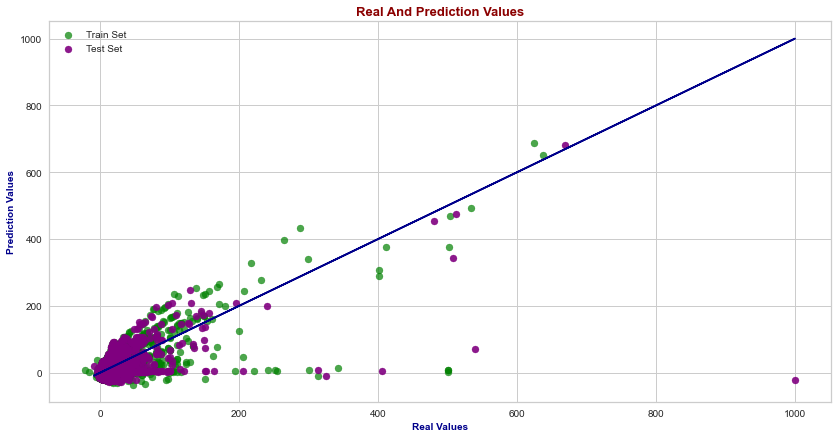

In [86]:
train_pred= model.predict(X_train)
test_pred= model.predict(X_test)

plt.figure(figsize=(14,7))
ax1= plt.scatter(y_train, train_pred, alpha=0.7, color="green")
ax2= plt.scatter(y_test, test_pred, alpha=0.9, color="purple")
ax3= plt.plot(y_test, y_test, color="darkblue")
plt.title("Real And Prediction Values", fontdict=title_font)
plt.xlabel("Real Values", fontdict=label_font)
plt.ylabel("Prediction Values",fontdict=label_font)
plt.legend([ax1,ax2], ["Train Set", "Test Set"])
plt.show()

In [87]:
print("Root Mean Squared Error Of Test Set: {}".format(np.sqrt(mse(y_test, test_pred))))
print("Root Mean Squared Error Of Train Set: {}".format(np.sqrt(mse(y_train, train_pred))))

Root Mean Squared Error Of Test Set: 2.5291562937705576
Root Mean Squared Error Of Train Set: 2.2312691634640074


#### Applying LSTM

Our goal is predict of 2015-10-31 monthly sales. <br/> Preparing data to LSTM.

In [46]:
df["date"]= pd.to_datetime(df[["year", "month", "day"]])
df.head()

,date_block_num,item_id,shop_id,item_price,total_revenue,month,day,year,item_cnt_day,season_autumn,season_spring,season_summer,season_winter,cluster,date
0,0,19,25,28.000000,28.000000,1,12,2013,1.000000,0,0,0,1,9,2013-01-12
75931,0,13890,27,349.000000,349.000000,1,24,2013,1.000000,0,0,0,1,9,2013-01-24
75930,0,13890,27,349.000000,349.000000,1,18,2013,1.000000,0,0,0,1,9,2013-01-18
75929,0,13890,27,349.000000,349.000000,1,2,2013,1.000000,0,0,0,1,9,2013-01-02
75928,0,13890,27,349.000000,349.000000,1,1,2013,1.000000,0,0,0,1,9,2013-01-01


Sub-sample training set to reduce training time

In [47]:
train= df.copy()

We will create a pivot table for we get our data in desired form.

In [48]:
train= train.pivot_table(index=["shop_id", "item_id"], values=["item_cnt_day"],
                         columns=["date_block_num"], fill_value=0, aggfunc="sum")
train.reset_index(inplace=True)
train.head()

shop_id item_id item_cnt_day                        ...        \
date_block_num                            0   1  2  3  4  5  6  7  ... 24 25   
0                    0      30            0  31  0  0  0  0  0  0  ...  0  0   
1                    0      31            0  11  0  0  0  0  0  0  ...  0  0   
2                    0      32            6  10  0  0  0  0  0  0  ...  0  0   
3                    0      33            3   3  0  0  0  0  0  0  ...  0  0   
4                    0      35            1  14  0  0  0  0  0  0  ...  0  0   

                                        
date_block_num 26 27 28 29 30 31 32 33  
0               0  0  0  0  0  0  0  0  
1               0  0  0  0  0  0  0  0  
2               0  0  0  0  0  0  0  0  
3               0  0  0  0  0  0  0  0  
4               0  0  0  0  0  0  0  0  

[5 rows x 36 columns]

 Now we will merge our pivot table with the test_data 

In [49]:
train= pd.merge(df_test, train, how="left", on=["item_id", "shop_id"])
train.fillna(0, inplace=True)
train.head()

,ID,shop_id,item_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0,5,5037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,3.000000,1.000000,0.000000
1,1,5,5320,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,5,5233,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,0.000000,1.000000,3.000000,1.000000
3,3,5,5232,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
4,4,5,5268,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


We will drop id, shop_id and item_id because we do not need them on the model. We are teaching our model how to generate the next sequence 

In [50]:
train.drop(["ID", "item_id", "shop_id"], inplace=True, axis=1)
train.head()

,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,3.000000,1.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,0.000000,1.000000,3.000000,1.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Creating X and y values.

In [51]:
# we will keep all columns execpt the last one for creating X
X= np.expand_dims(train.values[:,:-1], axis=2)
# The last columns will be our label
y= train.values[:,-1:]
# We will split the X and y values as train and test set
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.3, random_state=123)

Looking the shapes

In [52]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (149940, 33, 1)
y_train shape: (149940, 1)
X_test shape: (64260, 33, 1)
y_test shape: (64260, 1)


Now, it's time to define the model

In [53]:
first= Sequential()
first.add(LSTM(units=64, activation="relu", return_sequences=True ,input_shape=(33,1,)))
second= Sequential()
second.add(Dropout(0.3))
model= Sequential()
merged= Concatenate([first, second])
model.add(merged)

In [54]:
model= Sequential()
model.add(LSTM(units=64,activation="relu", return_sequences=True, input_shape=(9, 1,), name="lstm_layer"))
model.add(Dropout(0.3))
model.add(LSTM(units=32, activation="relu", name="second_layer"))
model.add(Dropout(0.2))
model.add(Dense(units=16, activation="relu", name="third_layer"))
model.add(Dense(1))

Compiling the model

In [55]:
model.compile(optimizer="adam", loss="mse", metrics=["mean_squared_error"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_layer (LSTM)            (None, 9, 64)             16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 64)             0         
_________________________________________________________________
second_layer (LSTM)          (None, 32)                12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
third_layer (Dense)          (None, 16)                528       
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
__________________________________________________

Fitting the model

In [56]:
callback= keras.callbacks.EarlyStopping(monitor="loss", patience=10)
model.fit(X_train, y_train, epochs=30, batch_size=5000,verbose=2, callbacks=[callback]) 

Epoch 1/30
30/30 - 21s - loss: 4.9035 - mean_squared_error: 4.9035
Epoch 2/30
30/30 - 21s - loss: 4.6647 - mean_squared_error: 4.6647
Epoch 3/30
30/30 - 22s - loss: 6.3484 - mean_squared_error: 6.3484
Epoch 4/30
30/30 - 22s - loss: 4.9294 - mean_squared_error: 4.9294
Epoch 5/30
30/30 - 20s - loss: 3.9536 - mean_squared_error: 3.9536
Epoch 6/30
30/30 - 20s - loss: 16.8099 - mean_squared_error: 16.8099
Epoch 7/30
30/30 - 20s - loss: 5.2115 - mean_squared_error: 5.2115
Epoch 8/30
30/30 - 20s - loss: 6.4197 - mean_squared_error: 6.4197
Epoch 9/30
30/30 - 20s - loss: 10.8235 - mean_squared_error: 10.8235
Epoch 10/30
30/30 - 20s - loss: 8.9437 - mean_squared_error: 8.9437
Epoch 11/30
30/30 - 20s - loss: 4.6396 - mean_squared_error: 4.6396
Epoch 12/30
30/30 - 483s - loss: 4.6524 - mean_squared_error: 4.6524
Epoch 13/30
30/30 - 21s - loss: 16.0232 - mean_squared_error: 16.0232
Epoch 14/30
30/30 - 20s - loss: 6.5064 - mean_squared_error: 6.5064
Epoch 15/30
30/30 - 22s - loss: 5.0209 - mean_squa

Prediction

In [57]:
y_pred_train= model.predict(X_train)
y_pred_test= model.predict(X_test)

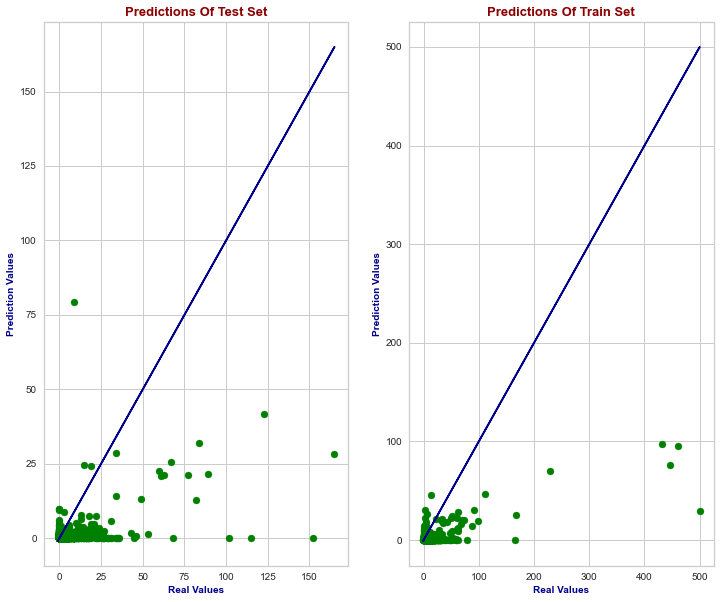

In [58]:
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
ax1= plt.scatter(y_test, y_pred_test, color="green")
ax2= plt.plot(y_test, y_test, color="darkblue")
plt.title("Predictions Of Test Set", fontdict=title_font)
plt.xlabel("Real Values", fontdict=label_font)
plt.ylabel("Prediction Values", fontdict=label_font)

plt.subplot(1,2,2)
ax1= plt.scatter(y_train, y_pred_train, color="green")
ax2= plt.plot(y_train, y_train, color="darkblue")
plt.title("Predictions Of Train Set", fontdict=title_font)
plt.xlabel("Real Values", fontdict=label_font)
plt.ylabel("Prediction Values", fontdict=label_font)
plt.show()

In [59]:
#For submission:
pred= model.predict(X)

In [60]:
submission = pd.DataFrame({'ID': df_test['ID'],'item_cnt_month':pred.ravel()})

In [61]:
submission.head() #Finaly! This is submission dataframe.

,ID,item_cnt_month
0,0,0.342745
1,1,0.188037
2,2,0.321850
3,3,0.204155
4,4,0.188037


In [62]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID              214200 non-null  int64  
 1   item_cnt_month  214200 non-null  float32
dtypes: float32(1), int64(1)
memory usage: 2.5 MB


In [79]:
submission.to_csv("/Users/ahmetemintek/Desktop/bitirme_projesi/submission.csv", header=True)

In [80]:
ss=pd.read_csv("/Users/ahmetemintek/Desktop/bitirme_projesi/submission.csv")
ss.head()

,Unnamed: 0,ID,item_cnt_month
0,0,0,0.342745
1,1,1,0.188037
2,2,2,0.321850
3,3,3,0.204155
4,4,4,0.188037


In [81]:
del ss["Unnamed: 0"]

In [83]:
ss.head()

,ID,item_cnt_month
0,0,0.342745
1,1,0.188037
2,2,0.321850
3,3,0.204155
4,4,0.188037


In [84]:
ss.to_csv("/Users/ahmetemintek/Desktop/bitirme_projesi/submission.csv")